# Deduplication

In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import sqlalchemy
from collections import Counter
import datetime
from __future__ import division
CONFIG_PATH = 'database.yml'
sns.set(color_codes=True)
%matplotlib inline
import collections
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
with open(CONFIG_PATH) as f:
    config = yaml.load(f)
engine = sqlalchemy.create_engine('postgres://', connect_args=config)

/Users/mbauman/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


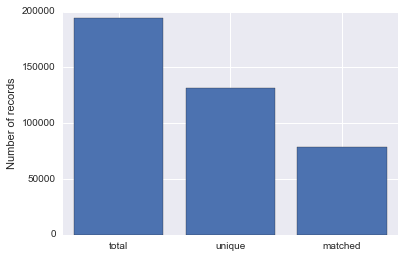

In [94]:
# Number of records/identities:
tot = engine.execute('SELECT count(*) from dedupe.entries').fetchone()[0]
uniq = engine.execute('SELECT count(*) from dedupe.entries_unique').fetchone()[0]
tot_matched = engine.execute('SELECT count(dedupe_id) from dedupe.entries').fetchone()[0]
plt.bar(range(3), [tot,uniq,tot_matched],tick_label=['total','unique','matched'],align='center');
plt.ylabel("Number of records");

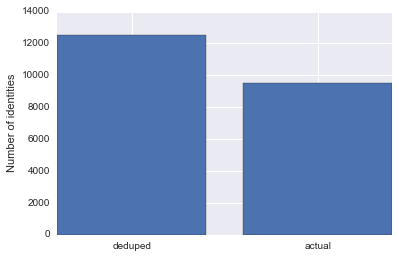

In [95]:
dedup = engine.execute('SELECT count(distinct dedupe_id) from dedupe.entries').fetchone()[0]
actual = engine.execute('SELECT count(distinct uuid) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [dedup,actual],tick_label=['deduped','actual'],align='center');
plt.ylabel("Number of identities");

# Falsely merged persons

In [61]:
df = pd.read_sql('SELECT dedupe_id, count(distinct uuid) from dedupe.entries where dedupe_id is not null group by dedupe_id', engine)
sum(df['count'] > 1)

61

In [62]:
dups = df[df['count'] > 1].dedupe_id
# First ten are all twins with off-by-one SSNs
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[10]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,721e33d8-5471-473a-8cc8-83b401af9d46,Kim,Ward,758-08-9550,F,1957-09-05,white,nonhispanic,186359,Kim Ward,10586
1,a8cd5429-a177-4029-9af5-385a3028946e,Megan,Ward,758-08-9549,F,1957-09-05,white,nonhispanic,34194,Megan Ward,10586
2,721e33d8-5471-473a-8cc8-83b401af9d46,Kimberly,Ward,758-08-9550,F,1957-09-05,white,nonhispanic,186355,Kimberly Ward,10586
3,721e33d8-5471-473a-8cc8-83b401af9d46,Kimberly,Ward,758-08-9550,F,1957-09-05,white,nonhispanic,186356,Kimberly Ward,10586
4,a8cd5429-a177-4029-9af5-385a3028946e,Megan,Ward,758-08-9549,F,1957-09-05,white,nonhispanic,34196,Megan Ward,10586
5,a8cd5429-a177-4029-9af5-385a3028946e,Megan,Ward,758-08-9549,F,1957-09-05,white,nonhispanic,34201,Megan Ward,10586
6,a8cd5429-a177-4029-9af5-385a3028946e,Megan,Ward,758-08-9549,F,1957-09-05,white,nonhispanic,34193,Megan Ward,10586


# Split identities

In [82]:
# Number of persons that got split into two identities
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) from dedupe.entries group by uuid', engine)
sum(df['count'] > 1)

2807

In [80]:
splits = df[df['count'] > 1].uuid
# Some of these are very obvious, and should have been captured:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(splits.iloc[2]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,00693488-5238-4252-b719-265867e90260,Lara,Kennedy,699-30-2127,F,1951-08-15,white,nonhispanic,103722,Lara Kennedy,16257
1,00693488-5238-4252-b719-265867e90260,Laura,Kennedy,699-20-2137,F,1951-08-15,white,nonhispanic,103720,Laura Kennedy,8528
2,00693488-5238-4252-b719-265867e90260,Laura,Kennedy,699-20-2137,F,1951-06-15,white,nonhispanic,103721,Laura Kennedy,8528


# Ignored persons

In [83]:
# Number of persons that were ignored entirely
sum(df['count'] == 0)

667

In [84]:
ignores = df[df['count'] == 0].uuid
# Not sure why it ignored some of these records, e.g.
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(ignores.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,004a6c45-a19a-4935-80a3-aaac9ebe450a,Mitchell,Cruz,445-32-3398,M,1980-07-29,None,nonhispanic,136574,Mitchell Cruz,None
1,004a6c45-a19a-4935-80a3-aaac9ebe450a,Mitchell,Cruz,445-32-3398,M,1980-07-29,None,None,136575,Mitchell Cruz,None


# Incomplete persons

In [85]:
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) as identities, count(dedupe_id)*1.0/count(*) as completeness from dedupe.entries group by uuid', engine)
sum(df[(df.identities == 1)].completeness < 1)

5761

In [86]:
incompletes = df[(df.identities == 1) & (df.completeness < 1)].uuid
# Not sure why it ignored some of these records, e.g.
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(incompletes.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powebl,080-64-6896,F,1983-06-19,black,nonhispanic,111346,Lisa Powebl,16563.0
1,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powell,080-64-6896,F,1983-06-19,black,nonhispanic,111347,Lisa Powell,16563.0
2,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powell,080-64-6896,F,1983-06-19,None,None,111348,Lisa Powell,NaN
3,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powell,080-64-6896,None,1983-06-19,asian,None,111349,Lisa Powell,NaN
4,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lika,Powell,080-64-6896,F,1983-12-08,None,nonhispanic,111350,Lika Powell,NaN
5,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Liz,Powell,None,F,1983-06-19,black,nonhispanic,111351,Liz Powell,NaN
